# Notebook de treinamento de redes convolucionais com os dados classificados por especialistas

Neste notebook treinamos diversas arquiteturas de redes convolucionais partindo dos pesos da ImageNet. Para este notebook, usamos apenas os dados anotados por especialistas e avaliamos as redes no conjunto de validação.

# Base de dados e importações

In [ ]:
!gdown --id 1lCN31ttToSzd28leuD1B9VbFtTUaWbfU --output dados.zip
!unzip dados.zip
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: melspectograma/24f7177c-c147-4ea8-9a9e-6f273d4f6fe4.jpg  
  inflating: melspectograma/9cefcba6-bea1-4131-a905-3d28e567344b.jpg  
  inflating: melspectograma/a4468aa1-4ce9-4965-a8c2-5b1860e1274d.jpg  
  inflating: melspectograma/bc36aed7-62e4-403d-992d-eb186cf2ccc1.jpg  
  inflating: melspectograma/da13dce6-31c9-411d-8ac6-3163892b9f8d.jpg  
  inflating: melspectograma/72418df9-2a0a-4da5-922d-7a1d5d12ab80.jpg  
  inflating: melspectograma/416c24b9-c0cc-4071-b55f-70ed103e02bc.jpg  
  inflating: melspectograma/901961a0-1c48-4a41-b247-1ff7034ed97d.jpg  
  inflating: melspectograma/3c46fbfe-cec8-41b3-9360-9e3e75a784de.jpg  
  inflating: melspectograma/21fc5063-f772-45be-992a-7af2b977ab12.jpg  
  inflating: melspectograma/3ba36da8-a4af-4dce-ad62-d3398d4c9cd5.jpg  
  inflating: melspectograma/5157deaa-f5f3-4a49-97ef-cd7ae396d446.jpg  
  inflating: melspectograma/70e16d99-c4b2-4d6b-a7c2-8d6b7e8fe68a.jpg  
  inflating: melsp

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.jpg'
val['uuid'] = val['uuid'] + '.jpg'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.3982300884955752
*   symptomatic -  represenatado pelo 1 - ficou com o peso 1.0 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 1.5906040268456376

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.3982300884955752, 1: 1.0, 2: 1.5906040268456376}

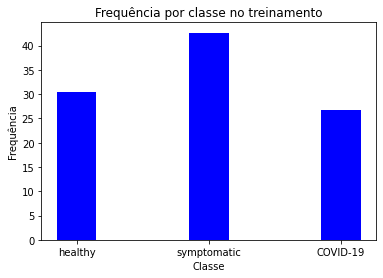

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-especialista.png')

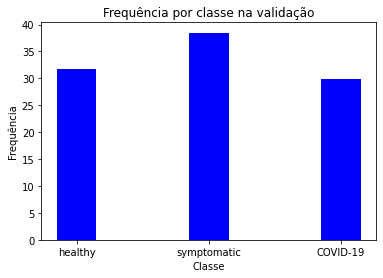

In [ ]:
plt.bar(0, len(val.values[val.classInt.values == 0])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(1, len(val.values[val.classInt.values == 1])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(2, len(val.values[val.classInt.values == 2])/len(val.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe na validação')
plt.savefig('Validacao.png')

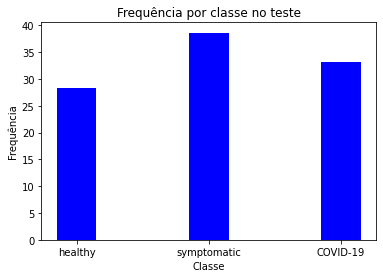

In [ ]:
teste = pd.read_csv('/content/CSV/test.csv')
teste['classInt'] = teste['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
plt.bar(0, len(teste.values[teste.classInt.values == 0])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(1, len(teste.values[teste.classInt.values == 1])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(2, len(teste.values[teste.classInt.values == 2])/len(teste.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no teste')
plt.savefig('Teste.png')

# Função para treinamento de modelos

Como foi analisado que a execução de uma época da rede dura poucos segundos iremos testar a base com esse pré-processamento em 21 redes diferentes da imagenet para ver qual obteve a melhor acurácia tornando-a por fim o nosso baseline inicial. As redes a serem analisadas são listadas abaixo:

ResNet50
ResNet101	
ResNet152	
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5	
EfficientNetB6	
EfficientNetB7	
MobileNet	
MobileNetV2	
DenseNet121	
DenseNet169	
DenseNet201	
InceptionV3	
InceptionResNetV2	
Xception	
VGG16	
VGG19	

In [ ]:
def cria_e_treina_rede(model_name, train_df, val_df, batch_size=32, callbacks=[], image_size=(256, 256), pooling='avg', loss='categorical_crossentropy', epochs=500, class_weights=class_weights, trainable=True):

  if model_name == 'resnet50' or model_name == 'resnet101' or model_name == 'resnet152':
    preprocessing_function = tf.keras.applications.resnet.preprocess_input
  elif model_name == 'efficientnetb0' or model_name == 'efficientnetb1' or model_name == 'efficientnetb2' or model_name == 'efficientnetb3' or model_name == 'efficientnetb4' or model_name == 'efficientnetb5'  or model_name == 'efficientnetb6' or model_name == 'efficientnetb7':
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
  elif model_name == 'mobilenet':
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
  elif model_name == 'mobilenetv2':
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
  elif model_name == 'densenet121' or model_name == 'densenet169' or model_name == 'densenet201':
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
  elif model_name == 'inceptionv3':
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
  elif model_name == 'inceptionresnetv2':
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input
  elif model_name == 'xception':
    preprocessing_function = tf.keras.applications.xception.preprocess_input
  elif model_name == 'vgg16':
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
  elif model_name == 'vgg19':
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_function,
  )

  train_generator = datagen.flow_from_dataframe(
    train_df, directory='/content/melspectograma', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42, color_mode='rgb')

  val_generator = datagen.flow_from_dataframe(
    val_df, directory='/content/melspectograma', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=False, seed=42, color_mode='rgb')
  
  if model_name == 'resnet50':
    pre_trained = tf.keras.applications.ResNet50(include_top=False, pooling=pooling)
  elif model_name == 'resnet101':
    pre_trained = tf.keras.applications.ResNet101(include_top=False, pooling=pooling)
  elif model_name == 'resnet152':
    pre_trained = tf.keras.applications.ResNet152(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb0':
    pre_trained = tf.keras.applications.EfficientNetB0(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb1':
    pre_trained = tf.keras.applications.EfficientNetB1(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb2':
    pre_trained = tf.keras.applications.EfficientNetB2(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb3':
    pre_trained = tf.keras.applications.EfficientNetB3(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb4':
    pre_trained = tf.keras.applications.EfficientNetB4(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb5':
    pre_trained = tf.keras.applications.EfficientNetB5(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb6':
    pre_trained = tf.keras.applications.EfficientNetB6(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb7':
    pre_trained = tf.keras.applications.EfficientNetB7(include_top=False, pooling=pooling)
  elif model_name == 'mobilenet':
    pre_trained = tf.keras.applications.MobileNet(include_top=False, pooling=pooling)
  elif model_name == 'mobilenetv2':
    pre_trained = tf.keras.applications.MobileNetV2(include_top=False, pooling=pooling)
  elif model_name == 'densenet121':
    pre_trained = tf.keras.applications.DenseNet121(include_top=False, pooling=pooling)
  elif model_name == 'densenet169':
    pre_trained = tf.keras.applications.DenseNet169(include_top=False, pooling=pooling)
  elif model_name == 'densenet201':
    pre_trained = tf.keras.applications.DenseNet201(include_top=False, pooling=pooling)
  elif model_name == 'inceptionv3':
    pre_trained = tf.keras.applications.InceptionV3(include_top=False, pooling=pooling)
  elif model_name == 'inceptionresnetv2':
    pre_trained = tf.keras.applications.InceptionResNetV2(include_top=False, pooling=pooling)
  elif model_name == 'xception':
    pre_trained = tf.keras.applications.Xception(include_top=False, pooling=pooling)
  elif model_name == 'vgg16':
    pre_trained = tf.keras.applications.VGG16(include_top=False, pooling=pooling)
  elif model_name == 'vgg19':
    pre_trained = tf.keras.applications.VGG19(include_top=False, pooling=pooling)

  for layer in pre_trained.layers:
    layer.treinable = trainable

  model = tf.keras.models.Sequential([
   pre_trained,
   tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.summary()

  optimizer = tf.keras.optimizers.Adam(0.000001)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/' + model_name + '.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(model_name + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_df): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelos

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 14s 270ms/step - loss: 1.8802 - acc: 0.2970 - val_loss: 1.9269 - val_acc: 0.2986
Epoch 2/500
35/35 [==============================] - 9s 244ms/step - loss: 1.7585 - acc: 0.3195 - val_loss: 1.7202 - val_acc: 0.2878
Epoch 3/500
35/35 [==============================] - 9s 244ms/step - loss: 1.6744 - acc: 0.3132 - val_loss: 1.5

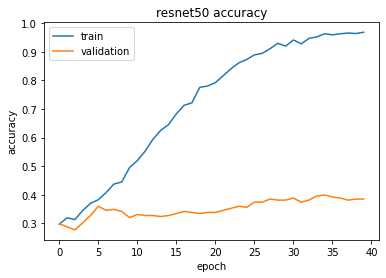

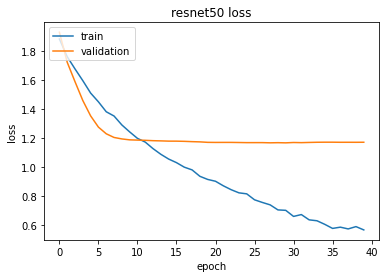

9/9 [==============================] - 1s 77ms/step
[[31 27 30]
 [38 43 26]
 [25 26 32]]
Acuracia balanceada na validacao: 0.3798946849419769


In [ ]:
cria_e_treina_rede('resnet50', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 42,558,979
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 25s 436ms/step - loss: 1.5581 - acc: 0.3222 - val_loss: 1.3076 - val_acc: 0.3201
Epoch 2/500
35/35 [==============================] - 14s 390ms/step - loss: 1.4796 - acc: 0.3600 - val_loss: 1.2147 - val_acc: 0.3885
Epoch 3/500
35/35 [==============================] - 14s 390ms/step - loss: 1.4171 - acc: 0.3996 - val_loss: 

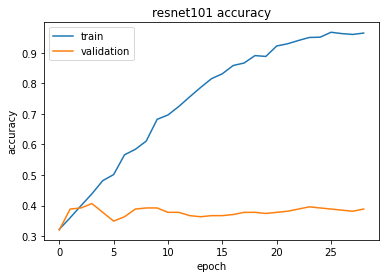

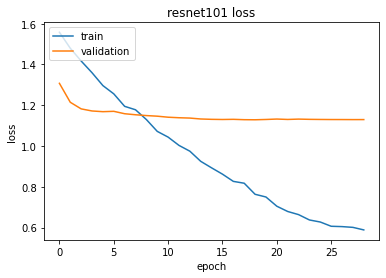

9/9 [==============================] - 2s 113ms/step
[[34 33 21]
 [35 44 28]
 [27 29 27]]
Acuracia balanceada na validacao: 0.3742932648179805


In [ ]:
cria_e_treina_rede('resnet101', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 6147      
Total params: 58,377,091
Trainable params: 58,225,667
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 35s 620ms/step - loss: 1.7476 - acc: 0.2997 - val_loss: 1.4133 - val_acc: 0.4065
Epoch 2/500
35/35 [==============================] - 19s 554ms/step - loss: 1.5974 - acc: 0.3204 - val_loss: 1.3684 - val_acc: 0.3993
Epoch 3/500
35/35 [==============================] - 19s 553ms/step - loss: 1.4842 - acc: 0.3492 - val_loss: 

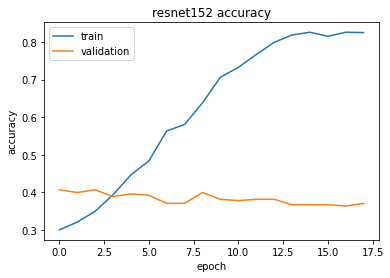

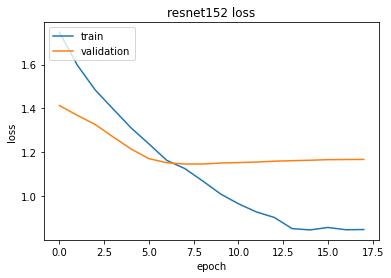

9/9 [==============================] - 3s 163ms/step
[[19 42 27]
 [19 54 34]
 [21 32 30]]
Acuracia balanceada na validacao: 0.3606759237459609


In [ ]:
cria_e_treina_rede('resnet152', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 18s 330ms/step - loss: 1.4626 - acc: 0.3393 - val_loss: 1.1443 - val_acc: 0.3058
Epoch 2/500
35/35 [==============================] - 10s 292ms/step - loss: 1.4696 - acc: 0.3312 - val_loss: 1.1428 - val_acc: 0.3273
Epoch 3/500
35/35 [==============================] - 10s 291ms/step - loss: 1.4565 - acc: 0.3546 - val_loss: 1.

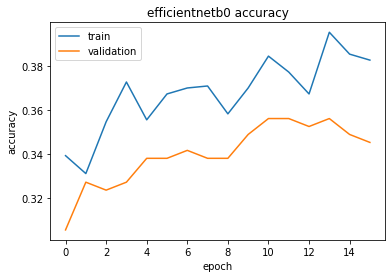

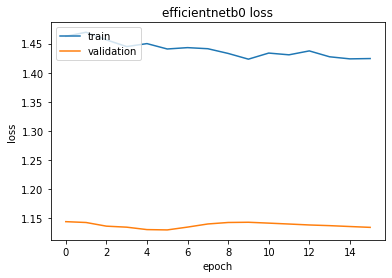

9/9 [==============================] - 2s 66ms/step
[[ 7 56 25]
 [17 65 25]
 [10 51 22]]
Acuracia balanceada na validacao: 0.3173607770077762


In [ ]:
cria_e_treina_rede('efficientnetb0', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 3843      
Total params: 6,579,082
Trainable params: 6,517,027
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 27s 474ms/step - loss: 1.4563 - acc: 0.3294 - val_loss: 1.1041 - val_acc: 0.3813
Epoch 2/500
35/35 [==============================] - 15s 425ms/step - loss: 1.4424 - acc: 0.3591 - val_loss: 1.1068 - val_acc: 0.3957
Epoch 3/500
35/35 [==============================] - 15s 427ms/step - loss: 1.4474 - acc: 0.3429 - val_loss: 1.

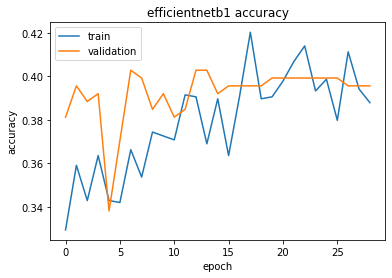

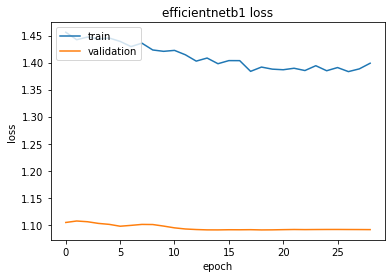

9/9 [==============================] - 2s 67ms/step
[[21 33 34]
 [22 49 36]
 [21 22 40]]
Acuracia balanceada na validacao: 0.39283599990446066


In [ ]:
cria_e_treina_rede('efficientnetb1', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
31793152/31790344 [==============================] - 1s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 4227      
Total params: 7,772,796
Trainable params: 7,705,221
Non-trainable params: 67,575
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 27s 500ms/step - loss: 1.4518 - acc: 0.3393 - val_loss: 1.1858 - val_acc: 0.3201
Epoch 2/500
35/35 [==============================] - 15s 439ms/step - loss: 1.4609 - acc: 0.3519 - val_loss: 1.1567 - val_acc: 0.2950
Epoch 3/500
35/35 [===========================

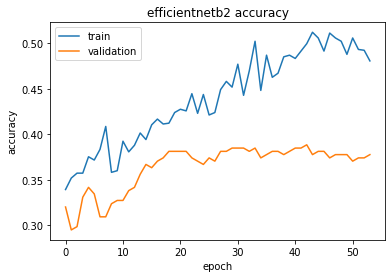

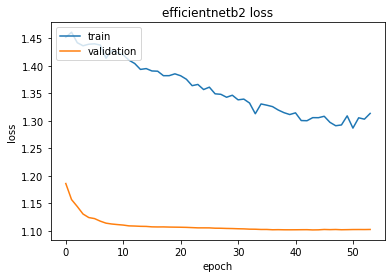

9/9 [==============================] - 2s 67ms/step
[[36 25 27]
 [34 43 30]
 [25 32 26]]
Acuracia balanceada na validacao: 0.37473769333920215


In [ ]:
cria_e_treina_rede('efficientnetb2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 4611      
Total params: 10,788,146
Trainable params: 10,700,843
Non-trainable params: 87,303
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 34s 616ms/step - loss: 1.4795 - acc: 0.3339 - val_loss: 1.1417 - val_acc: 0.3489
Epoch 2/500
35/35 [==============================] - 19s 534ms/step - loss: 1.4760 - acc: 0.3177 - val_loss: 1.1527 - val_acc: 0.3417
Epoch 3/500
35/35 [=========================

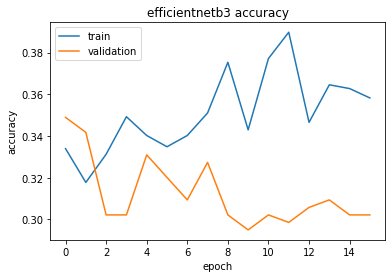

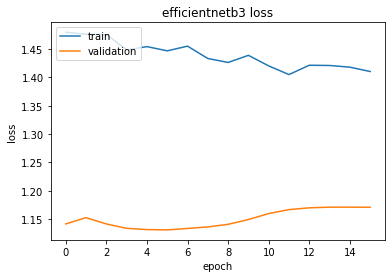

9/9 [==============================] - 2s 81ms/step
[[32 38 18]
 [49 32 26]
 [26 32 25]]
Acuracia balanceada na validacao: 0.32130220115807323


In [ ]:
cria_e_treina_rede('efficientnetb3', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
71688192/71686520 [==============================] - 2s 0us/step
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 5379      
Total params: 17,679,202
Trainable params: 17,553,995
Non-trainable params: 125,207
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 40s 740ms/step - loss: 1.4658 - acc: 0.2808 - val_loss: 1.1053 - val_acc: 0.3633
Epoch 2/500
35/35 [==============================] - 23s 661ms/step - loss: 1.4557 - acc: 0.2943 - val_loss: 1.1097 - val_acc: 0.3345
Epoch 3/500
35/35 [========================

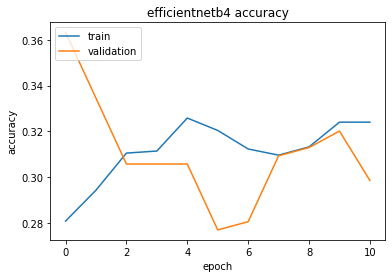

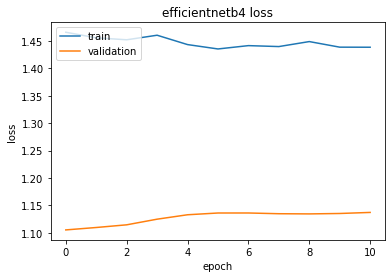

9/9 [==============================] - 3s 104ms/step
[[18 51 19]
 [25 65 17]
 [12 53 18]]
Acuracia balanceada na validacao: 0.34296318664633046


In [ ]:
cria_e_treina_rede('efficientnetb4', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
115269632/115263384 [==============================] - 2s 0us/step
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 6147      
Total params: 28,519,674
Trainable params: 28,346,931
Non-trainable params: 172,743
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 57s 545ms/step - loss: 1.4375 - acc: 0.3330 - val_loss: 1.1319 - val_acc: 0.2950
Epoch 2/500
70/70 [==============================] - 35s 495ms/step - loss: 1.4233 - acc: 0.3528 - val_loss: 1.1402 - val_acc: 0.2842
Epoch 3/500
70/70 [======================

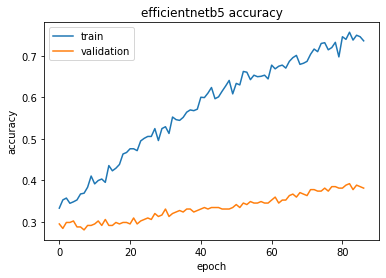

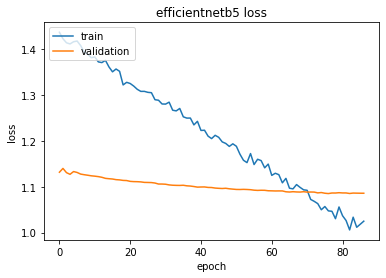

18/18 [==============================] - 4s 78ms/step
[[32 28 28]
 [38 39 30]
 [30 20 33]]
Acuracia balanceada na validacao: 0.3752375687968527


In [ ]:
cria_e_treina_rede('efficientnetb5', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
165240832/165234480 [==============================] - 3s 0us/step
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 2304)              40960143  
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 6915      
Total params: 40,967,058
Trainable params: 40,742,619
Non-trainable params: 224,439
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 67s 663ms/step - loss: 1.4322 - acc: 0.3258 - val_loss: 1.0889 - val_acc: 0.3669
Epoch 2/500
70/70 [==============================] - 43s 608ms/step - loss: 1.4210 - acc: 0.3384 - val_loss: 1.0940 - val_acc: 0.3633
Epoch 3/500
70/70 [======================

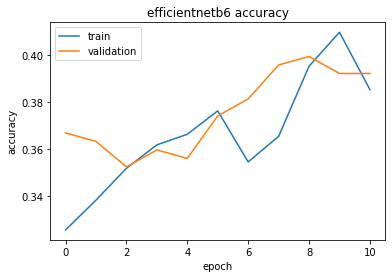

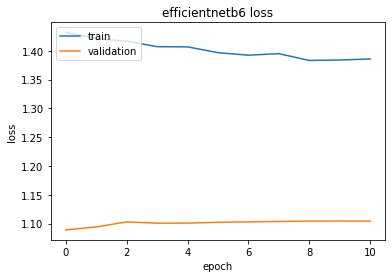

18/18 [==============================] - 7s 101ms/step
[[13 62 13]
 [15 74 18]
 [12 56 15]]
Acuracia balanceada na validacao: 0.3400129831134222


In [ ]:
cria_e_treina_rede('efficientnetb6', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
258080768/258076736 [==============================] - 2s 0us/step
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2560)              64097687  
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 7683      
Total params: 64,105,370
Trainable params: 63,794,643
Non-trainable params: 310,727
_________________________________________________________________
Epoch 1/500
139/139 [==============================] - 93s 493ms/step - loss: 1.4305 - acc: 0.3375 - val_loss: 1.1186 - val_acc: 0.3273
Epoch 2/500
139/139 [==============================] - 64s 461ms/step - loss: 1.4148 - acc: 0.3510 - val_loss: 1.1259 - val_acc: 0.3237
Epoch 3/500
139/139 [================

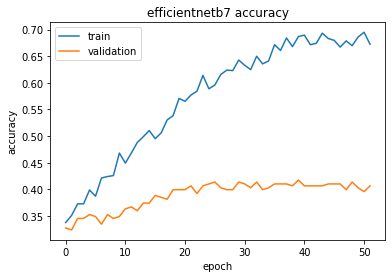

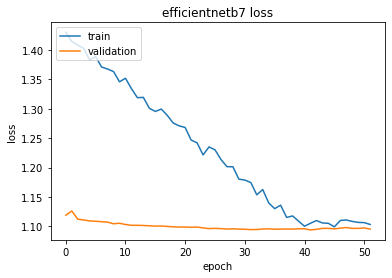

35/35 [==============================] - 6s 77ms/step
[[35 20 33]
 [35 36 36]
 [20 21 42]]
Acuracia balanceada na validacao: 0.4133999890812186


In [ ]:
cria_e_treina_rede('efficientnetb7', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=8)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 10s 231ms/step - loss: 1.7394 - acc: 0.3438 - val_loss: 1.2109 - val_acc: 0.3705
Epoch 2/500
35/35 [==============================] - 7s 207ms/step - loss: 1.7045 - acc: 0.3537 - val_loss: 1.2541 - val_acc: 0.3813
Epoch 3/500
35/35 [============================

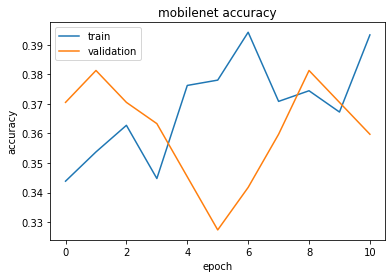

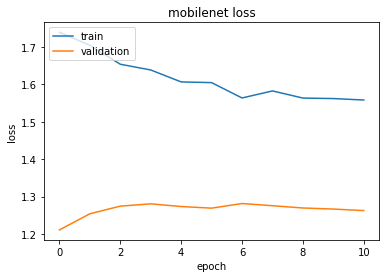

9/9 [==============================] - 1s 62ms/step
[[ 6 46 36]
 [ 5 61 41]
 [ 5 42 36]]
Acuracia balanceada na validacao: 0.3573367386282598


In [ ]:
cria_e_treina_rede('mobilenet', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 12s 252ms/step - loss: 1.5422 - acc: 0.3501 - val_loss: 1.4494 - val_acc: 0.3273
Epoch 2/500
35/35 [==============================] - 8s 224ms/step - loss: 1.5298 - acc: 0.3465 - val_loss: 1.4582 - val_acc: 0.3309
Epoch 3/500
35/35 [==============================

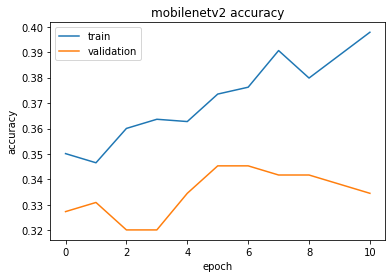

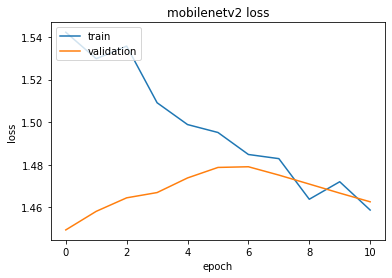

9/9 [==============================] - 1s 64ms/step
[[69  1 18]
 [81  0 26]
 [61  0 22]]
Acuracia balanceada na validacao: 0.34971705001825487


In [ ]:
cria_e_treina_rede('mobilenetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 21s 344ms/step - loss: 1.9740 - acc: 0.2835 - val_loss: 1.4486 - val_acc: 0.2842
Epoch 2/500
35/35 [==============================] - 9s 257ms/step - loss: 1.9279 - acc: 0.2925 - val_loss: 1.4348 - val_acc: 0.2986
Epoch 3/500
35/35 [============================

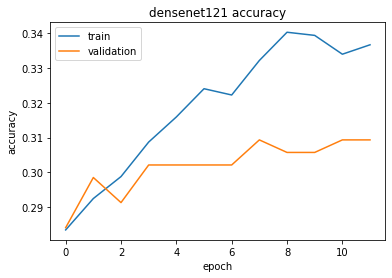

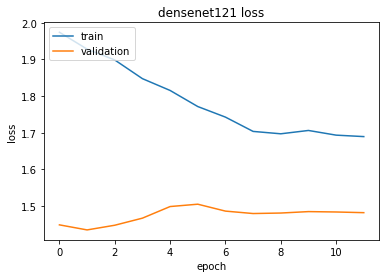

9/9 [==============================] - 2s 79ms/step
[[ 4  3 81]
 [ 9  0 98]
 [ 4  0 79]]
Acuracia balanceada na validacao: 0.332420591456736


In [ ]:
cria_e_treina_rede('densenet121', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
51879936/51877672 [==============================] - 2s 0us/step
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 12,489,475
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 26s 389ms/step - loss: 1.6186 - acc: 0.3915 - val_loss: 1.1966 - val_acc: 0.3777
Epoch 2/500
35/35 [==============================] - 11s 306ms/step - loss: 1.5655 - acc: 0.4050 - val_loss: 1.2039 - val_acc: 0.3777
Epoch 3/500
35/35 [========================

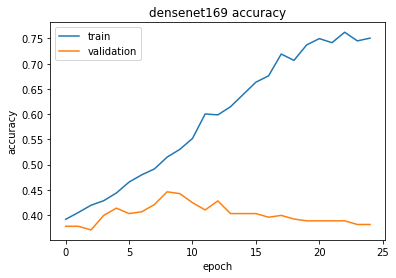

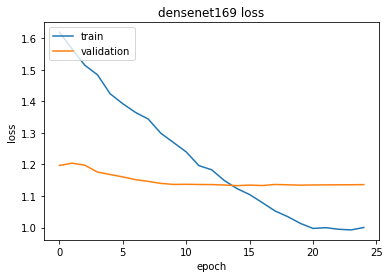

9/9 [==============================] - 3s 86ms/step
[[19 52 17]
 [20 70 17]
 [21 39 23]]
Acuracia balanceada na validacao: 0.3824077107068888


In [ ]:
cria_e_treina_rede('densenet169', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 18,098,691
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 36s 282ms/step - loss: 1.5682 - acc: 0.3051 - val_loss: 1.1867 - val_acc: 0.3813
Epoch 2/500
70/70 [==============================] - 15s 218ms/step - loss: 1.4996 - acc: 0.3267 - val_loss: 1.1984 - val_acc: 0.3345
Epoch 3/500
70/70 [========================

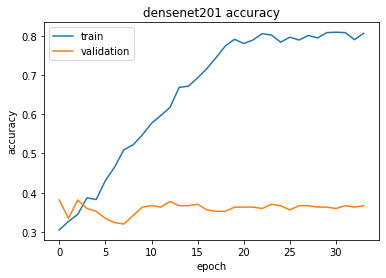

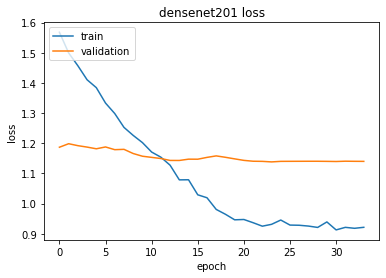

18/18 [==============================] - 3s 56ms/step
[[22 35 31]
 [19 46 42]
 [17 31 35]]
Acuracia balanceada na validacao: 0.3671977630146756


In [ ]:
cria_e_treina_rede('densenet201', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 16s 146ms/step - loss: 1.5216 - acc: 0.3870 - val_loss: 1.1552 - val_acc: 0.3345
Epoch 2/500
70/70 [==============================] - 8s 118ms/step - loss: 1.4868 - acc: 0.4014 - val_loss: 1.1301 - val_acc: 0.3777
Epoch 3/500
70/70 [==========================

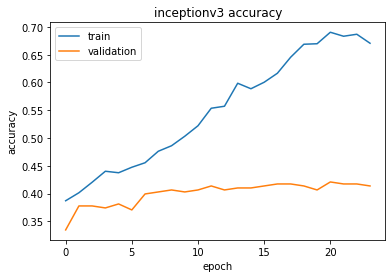

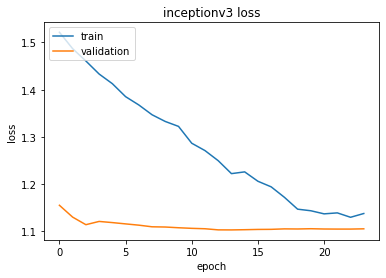

18/18 [==============================] - 2s 38ms/step
[[31 39 18]
 [31 53 23]
 [26 27 30]]
Acuracia balanceada na validacao: 0.4030152044029986


In [ ]:
cria_e_treina_rede('inceptionv3', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
219062272/219055592 [==============================] - 4s 0us/step
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 38s 562ms/step - loss: 1.4868 - acc: 0.3006 - val_loss: 1.2105 - val_acc: 0.3453
Epoch 2/500
35/35 [==============================] - 16s 447ms/step - loss: 1.4629 - acc: 0.3141 - val_loss: 1.2277 - val_acc: 0.3309
Epoch 3/500
35/35 [=======================

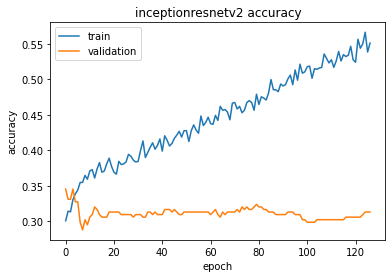

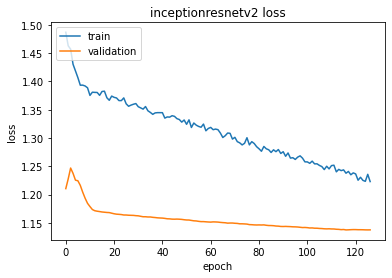

9/9 [==============================] - 4s 121ms/step
[[48  5 35]
 [74  9 24]
 [49  6 28]]
Acuracia balanceada na validacao: 0.322305364192539


In [ ]:
cria_e_treina_rede('inceptionresnetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
83689472/83683744 [==============================] - 2s 0us/step
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/500
35/35 [==============================] - 24s 564ms/step - loss: 1.4112 - acc: 0.3114 - val_loss: 1.0970 - val_acc: 0.4029
Epoch 2/500
35/35 [==============================] - 18s 522ms/step - loss: 1.4085 - acc: 0.3105 - val_loss: 1.1029 - val_acc: 0.3777
Epoch 3/500
35/35 [=========================

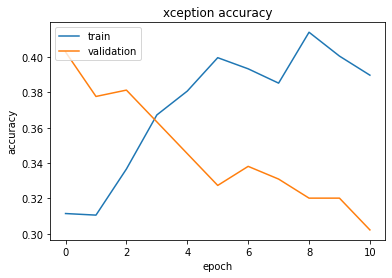

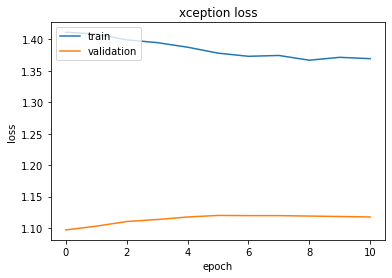

9/9 [==============================] - 1s 93ms/step
[[17 59 12]
 [13 83 11]
 [12 59 12]]
Acuracia balanceada na validacao: 0.3711536886714231


In [ ]:
cria_e_treina_rede('xception', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
58892288/58889256 [==============================] - 2s 0us/step
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 16s 181ms/step - loss: 2.9959 - acc: 0.3699 - val_loss: 1.7723 - val_acc: 0.3345
Epoch 2/500
70/70 [==============================] - 10s 148ms/step - loss: 1.8026 - acc: 0.3789 - val_loss: 1.5377 - val_acc: 0.3309
Epoch 3/500
70/70 [==============================

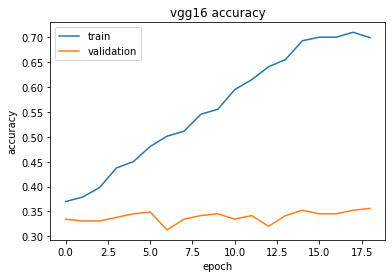

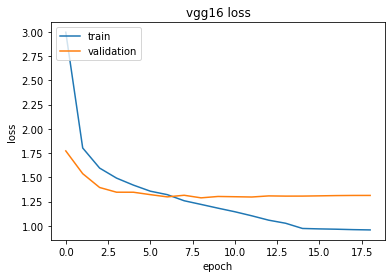

18/18 [==============================] - 1s 38ms/step
[[29 35 24]
 [38 41 28]
 [27 31 25]]
Acuracia balanceada na validacao: 0.337975947972007


In [ ]:
cria_e_treina_rede('vgg16', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 [==============================] - 13s 176ms/step - loss: 2.8805 - acc: 0.3528 - val_loss: 1.4509 - val_acc: 0.3273
Epoch 2/500
70/70 [==============================] - 12s 172ms/step - loss: 1.7491 - acc: 0.3708 - val_loss: 1.2285 - val_acc: 0.3705
Epoch 3/500
70/70 [==============================

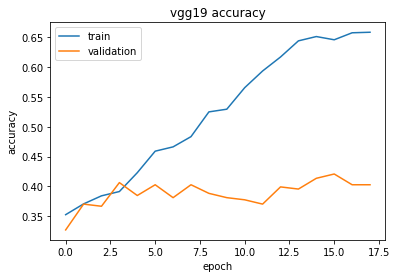

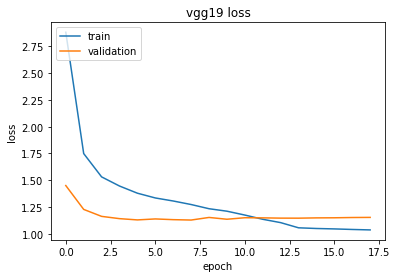

18/18 [==============================] - 1s 44ms/step
[[45 21 22]
 [50 42 15]
 [31 27 25]]
Acuracia balanceada na validacao: 0.4016972733755753


In [ ]:
cria_e_treina_rede('vgg19', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)